In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
test_loader = DataLoader(testset, batch_size=10000, shuffle=True)

# Download and load the OOD data
oodset = datasets.MNIST('./data', download=True, train=False, transform=transform)
ood_loader = DataLoader(oodset, batch_size=10000, shuffle=True)

In [4]:
print(trainset)
print(testset)
print(oodset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [6]:
class MultilayerAutoEncoder(nn.Module):
    
    def __init__(self):
        super(MultilayerAutoEncoder, self).__init__()
        
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28,28),
            nn.ReLU(),
            nn.Linear(28,250),
            nn.ReLU(),
            #Latent View
            nn.Linear(250,10)
            )
        
        #Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10,250),
            nn.ReLU(),
            nn.Linear(250,500),
            nn.ReLU(),
            nn.Linear(500,28*28)
        )
        
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,x):
        return self.decoder(x)
        
    def forward(self,x):
        #x = x.reshape(64,1,28*28)
        #print(x.size())
        x = self.encoder(x)
        x = torch.sigmoid(x)
        x = self.decoder(x)
        #x = x.reshape(64,1,28,28)
        return x

In [7]:
# creating model,and defining optimizer and loss
model = MultilayerAutoEncoder()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

We're using => cuda:0
MultilayerAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=28, bias=True)
    (1): ReLU()
    (2): Linear(in_features=28, out_features=250, bias=True)
    (3): ReLU()
    (4): Linear(in_features=250, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=784, bias=True)
  )
)


In [8]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

T-shirt/Top
torch.Size([64, 1, 28, 28]) torch.Size([64])


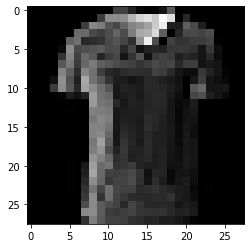

In [9]:
image, label = next(iter(train_loader))
plt.imshow(image[10].squeeze(), cmap="gray")
print(output_label(label[10]))
print(image.size(), label.size())

In [11]:
clr_map = {
    0:"blue",
    1:"orange",
    2:"red",
    3:"brown",
    4:"cyan",
    5:"green",
    6:"olive",
    7:"pink",
    8:"purple",
    9:"gray",
    }

In [12]:
def Accuracy(y_pred, y_test):
    _, y_pred_tags = torch.max(y_pred, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [23]:
print("Begin training.")
for e in tqdm(range(15)):
    # TRAINING
    train_epoch_loss = 0
    #train_epoch_acc = 0
    batch_num = 1
    model.train()
    for X_train_batch, y_train_batch in tqdm(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        X_train_batch = X_train_batch.view(X_train_batch.size(0), -1)
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, X_train_batch)
        #train_acc = Accuracy(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        #train_epoch_acc += train_acc.item()
        #print(f'{batch_num+0:02}: | Train Acc: {train_acc} | Train Loss: {train_loss.item()}')
        batch_num += 1
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f}')

Begin training.



Epoch 00: | Train Loss: 0.06284



Epoch 01: | Train Loss: 0.06155



Epoch 02: | Train Loss: 0.06047



Epoch 03: | Train Loss: 0.05958



Epoch 04: | Train Loss: 0.05883



Epoch 05: | Train Loss: 0.05818



Epoch 06: | Train Loss: 0.05765



Epoch 07: | Train Loss: 0.05716



Epoch 08: | Train Loss: 0.05670



Epoch 09: | Train Loss: 0.05630



Epoch 10: | Train Loss: 0.05594



Epoch 11: | Train Loss: 0.05561



Epoch 12: | Train Loss: 0.05533



Epoch 13: | Train Loss: 0.05503



Epoch 14: | Train Loss: 0.05482



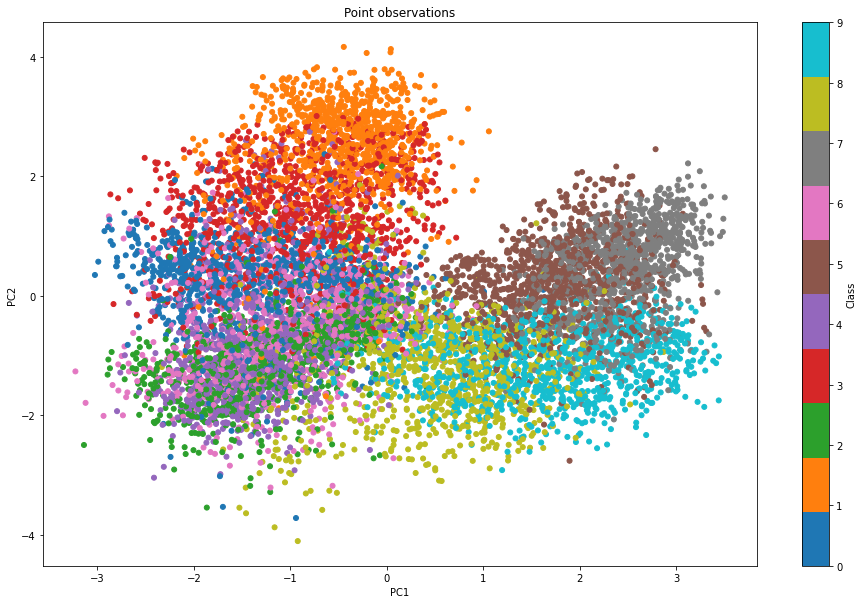

In [24]:
#TESTING PCA visualization in-distribution
plt.figure(figsize=(16,10))
plt.title("Point observations")
plt.xlabel("PC1")
plt.ylabel("PC2")
marker_size=25

pca = PCA(n_components=2)
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        pca_result = pca.fit_transform(y_test_pred.cpu().detach().numpy())
        plt.scatter(pca_result[:,0], pca_result[:,1], marker_size, c=y_batch.cpu(), cmap='tab10')
cbar = plt.colorbar()
cbar.set_label("Class")
plt.show()

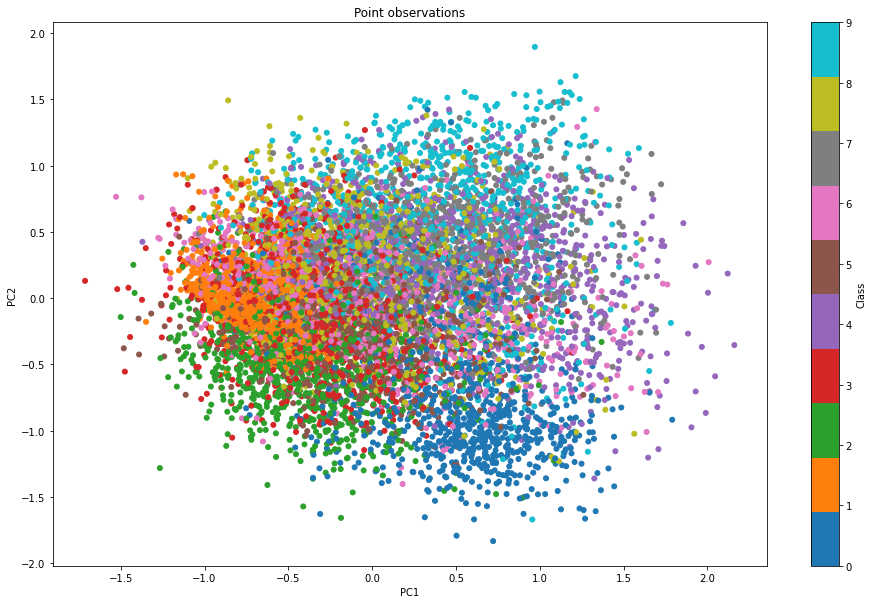

In [25]:
#TESTING PCA visualization out-distribution
plt.figure(figsize=(16,10))
plt.title("Point observations")
plt.xlabel("PC1")
plt.ylabel("PC2")
marker_size=25

pca = PCA(n_components=2)
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        pca_result = pca.fit_transform(y_test_pred.cpu().detach().numpy())
        plt.scatter(pca_result[:,0], pca_result[:,1], marker_size, c=y_batch.cpu(), cmap='tab10')
cbar = plt.colorbar()
cbar.set_label("Class")
plt.show()

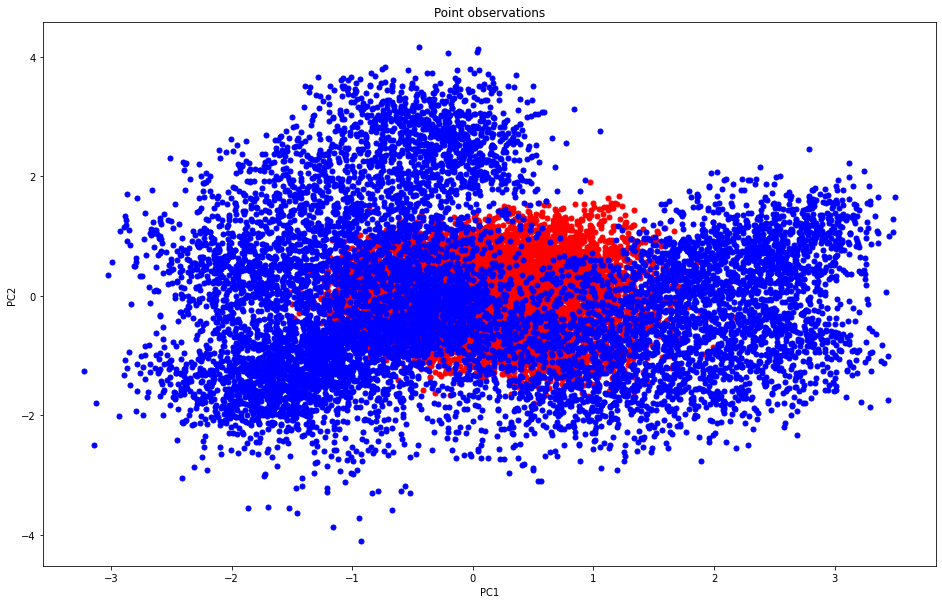

In [26]:
#TESTING PCA visualization in and out distribution together
plt.figure(figsize=(16,10))
plt.title("Point observations")
plt.xlabel("PC1")
plt.ylabel("PC2")
marker_size=25


model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        pca_result = PCA(n_components=2).fit_transform(y_test_pred.cpu().detach().numpy())
        plt.scatter(pca_result[:,0], pca_result[:,1], marker_size, c='r')
        
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        pca_result = PCA(n_components=2).fit_transform(y_test_pred.cpu().detach().numpy())
        plt.scatter(pca_result[:,0], pca_result[:,1], marker_size, c='b')
plt.show()

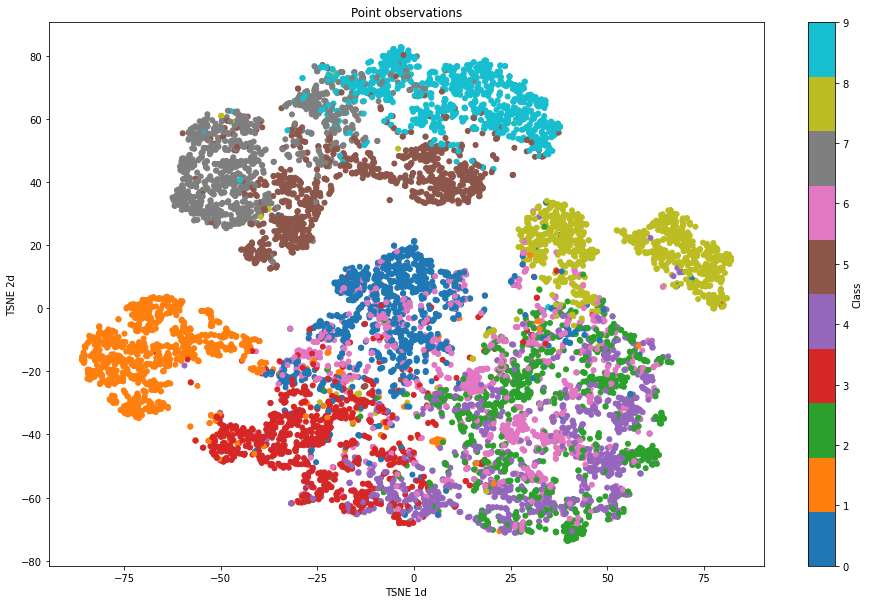

In [27]:
#TESTING TSNE visualization in-distribution
plt.figure(figsize=(16,10))
plt.title("Point observations")
plt.xlabel("TSNE 1d")
plt.ylabel("TSNE 2d")
marker_size=25

tsne = TSNE(n_components=2)
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        tsne_result = tsne.fit_transform(y_test_pred.cpu().detach().numpy())
        plt.scatter(tsne_result[:,0], tsne_result[:,1], marker_size, c=y_batch.cpu(), cmap='tab10')
cbar = plt.colorbar()
cbar.set_label("Class")
plt.show()

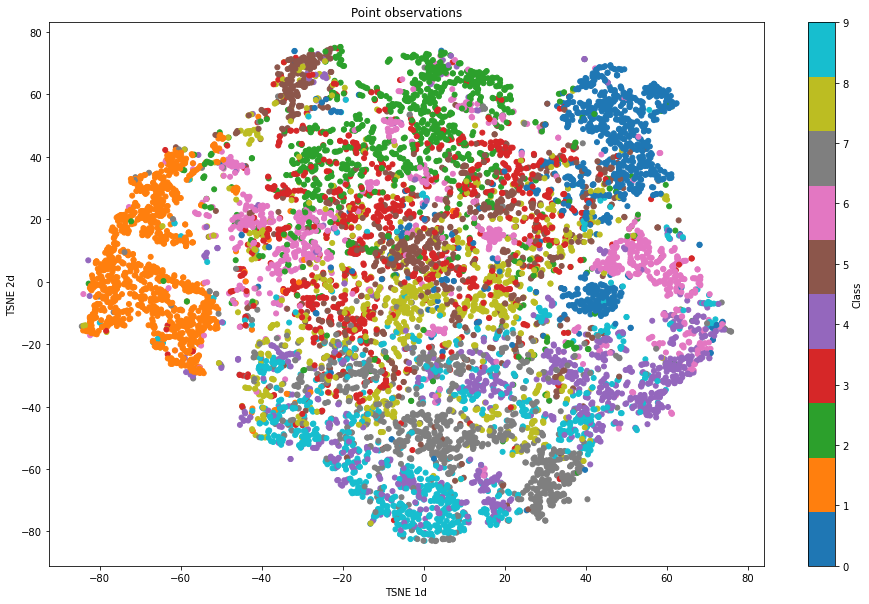

In [28]:
#TESTING TSNE visualization out-distribution
plt.figure(figsize=(16,10))
plt.title("Point observations")
plt.xlabel("TSNE 1d")
plt.ylabel("TSNE 2d")
marker_size=25

tsne = TSNE(n_components=2)
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        tsne_result = tsne.fit_transform(y_test_pred.cpu().detach().numpy())
        plt.scatter(tsne_result[:,0], tsne_result[:,1], marker_size, c=y_batch.cpu(), cmap='tab10')
cbar = plt.colorbar()
cbar.set_label("Class")
plt.show()

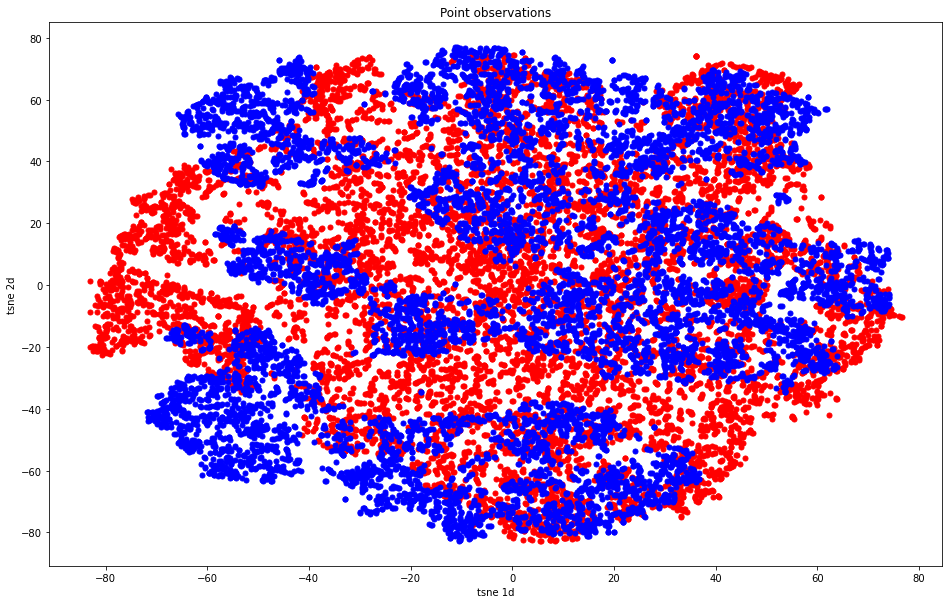

In [29]:
#TESTING TSNE visualization in and out distribution together
plt.figure(figsize=(16,10))
plt.title("Point observations")
plt.xlabel("tsne 1d")
plt.ylabel("tsne 2d")
marker_size=25


model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        tsne_result = TSNE(n_components=2).fit_transform(y_test_pred.cpu().detach().numpy())
        plt.scatter(tsne_result[:,0], tsne_result[:,1], marker_size, c='r')
        
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        tsne_result = TSNE(n_components=2).fit_transform(y_test_pred.cpu().detach().numpy())
        plt.scatter(tsne_result[:,0], tsne_result[:,1], marker_size, c='b')
plt.show()